In [1]:
import pandas as pd

data = pd.read_csv("C:/Users/ProUser/Documents/TSFN Datathon/rice_only.csv")
data = data[data['Continent'] == 'Asia']
data.head()

,country,commodity,year,loss_percentage,loss_quantity,activity,treatment,cause_of_loss,Stage,Continent
0,Myanmar,"Rice, milled",2015,1.78,26.12kgs,Storage,"30 days storage, with trapping",Rodents,Post-Harvest Handling and Storage,Asia
1,Myanmar,"Rice, milled",2015,11.77,88.18kgs,Storage,"60 days storage, no trapping",Rodents,Post-Harvest Handling and Storage,Asia
2,Myanmar,"Rice, milled",2015,5.88,44.09kgs,Storage,"30 days storage, no trapping",Rodents,Post-Harvest Handling and Storage,Asia
3,Myanmar,"Rice, milled",2015,3.57,52.24kgs,Storage,"60 days storage, with trapping",Rodents,Post-Harvest Handling and Storage,Asia
4,Myanmar,"Rice, milled",2015,17.65,132.27kgs,Storage,"90 days storage, no trapping",Rodents,Post-Harvest Handling and Storage,Asia


In [2]:
data['country'].unique()

array(['Myanmar', 'China', 'India', 'Indonesia', 'Republic of Korea',
       'Malaysia', 'Bangladesh', 'Nepal', 'Philippines', 'Timor-Leste',
       'Saudi Arabia', 'Viet Nam', 'Thailand'], dtype=object)

In [3]:
data.drop(['cause_of_loss','treatment','loss_quantity'],axis = 1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 558 entries, 0 to 4924
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          558 non-null    object 
 1   commodity        558 non-null    object 
 2   year             558 non-null    int64  
 3   loss_percentage  558 non-null    float64
 4   activity         558 non-null    object 
 5   Stage            558 non-null    object 
 6   Continent        558 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 34.9+ KB


In [4]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

label_encoders = {}
categorical_columns = ['country', 'Continent', 'activity', 'Stage', 'commodity']

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

data.info()
data.sort_values('year', inplace=True)

train_end_year = 2022
forecast_years = 10

train_data = data[data['year'] <= train_end_year]
validation_data = data[data['year'] > train_end_year]

forecast_dfs = []

for _, group in train_data.groupby(['country', 'Continent', 'activity', 'Stage', 'commodity']):
    if len(group) < 3:  
        continue

    model = SARIMAX(group['loss_percentage'], order=(1, 1, 1))
    results = model.fit()

    forecast = results.forecast(steps=forecast_years)

    group_forecast_df = pd.DataFrame({'year': range(train_end_year + 1, train_end_year + 1 + forecast_years),
                                      'forecast_loss_percentage': forecast,
                                      'country': group['country'].iloc[0],
                                      'Continent': group['Continent'].iloc[0],  
                                      'activity': group['activity'].iloc[0],
                                      'Stage': group['Stage'].iloc[0],
                                      'commodity': group['commodity'].iloc[0]})

    forecast_dfs.append(group_forecast_df)

forecast_df = pd.concat(forecast_dfs, ignore_index=True)

forecast_df['country'] = label_encoders['country'].inverse_transform(forecast_df['country'])
forecast_df['Continent'] = label_encoders['Continent'].inverse_transform(forecast_df['Continent'])
forecast_df['activity'] = label_encoders['activity'].inverse_transform(forecast_df['activity'])
forecast_df['Stage'] = label_encoders['Stage'].inverse_transform(forecast_df['Stage'])
forecast_df['commodity'] = label_encoders['commodity'].inverse_transform(forecast_df['commodity'])

print(forecast_df)


<class 'pandas.core.frame.DataFrame'>
Index: 558 entries, 0 to 4924
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          558 non-null    int32  
 1   commodity        558 non-null    int32  
 2   year             558 non-null    int64  
 3   loss_percentage  558 non-null    float64
 4   activity         558 non-null    int32  
 5   Stage            558 non-null    int32  
 6   Continent        558 non-null    int32  
dtypes: float64(1), int32(5), int64(1)
memory usage: 24.0 KB


c:\Users\ProUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ProUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ProUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ProUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an

     year  forecast_loss_percentage     country Continent  activity   
0    2023                  7.368392  Bangladesh      Asia  Cleaning  \
1    2024                  7.298154  Bangladesh      Asia  Cleaning   
2    2025                  7.303770  Bangladesh      Asia  Cleaning   
3    2026                  7.303321  Bangladesh      Asia  Cleaning   
4    2027                  7.303357  Bangladesh      Asia  Cleaning   
..    ...                       ...         ...       ...       ...   
285  2028                  7.708172     Myanmar      Asia   Storage   
286  2029                  7.708349     Myanmar      Asia   Storage   
287  2030                  7.708319     Myanmar      Asia   Storage   
288  2031                  7.708324     Myanmar      Asia   Storage   
289  2032                  7.708323     Myanmar      Asia   Storage   

                                 Stage     commodity  
0             Processing and Packaging          Rice  
1             Processing and Packagin

c:\Users\ProUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ProUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\ProUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\ProUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. fo

In [5]:
forecast_df.head()

,year,forecast_loss_percentage,country,Continent,activity,Stage,commodity
0,2023,7.368392,Bangladesh,Asia,Cleaning,Processing and Packaging,Rice
1,2024,7.298154,Bangladesh,Asia,Cleaning,Processing and Packaging,Rice
2,2025,7.303770,Bangladesh,Asia,Cleaning,Processing and Packaging,Rice
3,2026,7.303321,Bangladesh,Asia,Cleaning,Processing and Packaging,Rice
4,2027,7.303357,Bangladesh,Asia,Cleaning,Processing and Packaging,Rice


In [6]:
forecast_df.to_csv("forecast_loss_in_supply_chain.csv",index=False)

In [7]:
asia = forecast_df[forecast_df['Continent'] == 'Asia']
asia.head()

,year,forecast_loss_percentage,country,Continent,activity,Stage,commodity
0,2023,7.368392,Bangladesh,Asia,Cleaning,Processing and Packaging,Rice
1,2024,7.298154,Bangladesh,Asia,Cleaning,Processing and Packaging,Rice
2,2025,7.303770,Bangladesh,Asia,Cleaning,Processing and Packaging,Rice
3,2026,7.303321,Bangladesh,Asia,Cleaning,Processing and Packaging,Rice
4,2027,7.303357,Bangladesh,Asia,Cleaning,Processing and Packaging,Rice


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

historical = pd.read_csv("C:/Users/ProUser/Documents/TSFN Datathon/rice_only.csv")
historical = historical[historical['Continent'] == 'Asia']

future = pd.read_csv("C:/Users\ProUser/Documents/TSFN Datathon/forecast_loss_in_supply_chain.csv")
future = future[future['Continent'] == 'Asia']

combined = pd.concat([historical, future], ignore_index=True)

combined.head()


,country,commodity,year,loss_percentage,loss_quantity,activity,treatment,cause_of_loss,Stage,Continent,forecast_loss_percentage
0,Myanmar,"Rice, milled",2015,1.78,26.12kgs,Storage,"30 days storage, with trapping",Rodents,Post-Harvest Handling and Storage,Asia,NaN
1,Myanmar,"Rice, milled",2015,11.77,88.18kgs,Storage,"60 days storage, no trapping",Rodents,Post-Harvest Handling and Storage,Asia,NaN
2,Myanmar,"Rice, milled",2015,5.88,44.09kgs,Storage,"30 days storage, no trapping",Rodents,Post-Harvest Handling and Storage,Asia,NaN
3,Myanmar,"Rice, milled",2015,3.57,52.24kgs,Storage,"60 days storage, with trapping",Rodents,Post-Harvest Handling and Storage,Asia,NaN
4,Myanmar,"Rice, milled",2015,17.65,132.27kgs,Storage,"90 days storage, no trapping",Rodents,Post-Harvest Handling and Storage,Asia,NaN


In [9]:
combined.drop(['cause_of_loss','treatment','loss_quantity'],axis = 1, inplace=True)
field = combined[combined['activity'] == 'Field']
shelling = combined[combined['activity'] == 'Shelling']
distribution = combined[combined['activity'] == 'Distribution']
milling = combined[combined['activity'] == 'Milling']
stacking = combined[combined['activity'] == 'Stacking'] 

In [10]:
combined.to_csv('combined.csv',index=False)

C:\Users\ProUser\AppData\Local\Temp\ipykernel_7344\1510886353.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_stage['year'] = historical_stage['year'].round().astype(int)
C:\Users\ProUser\AppData\Local\Temp\ipykernel_7344\1510886353.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_stage['year'] = future_stage['year'].round().astype(int)
C:\Users\ProUser\AppData\Local\Temp\ipykernel_7344\1510886353.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.


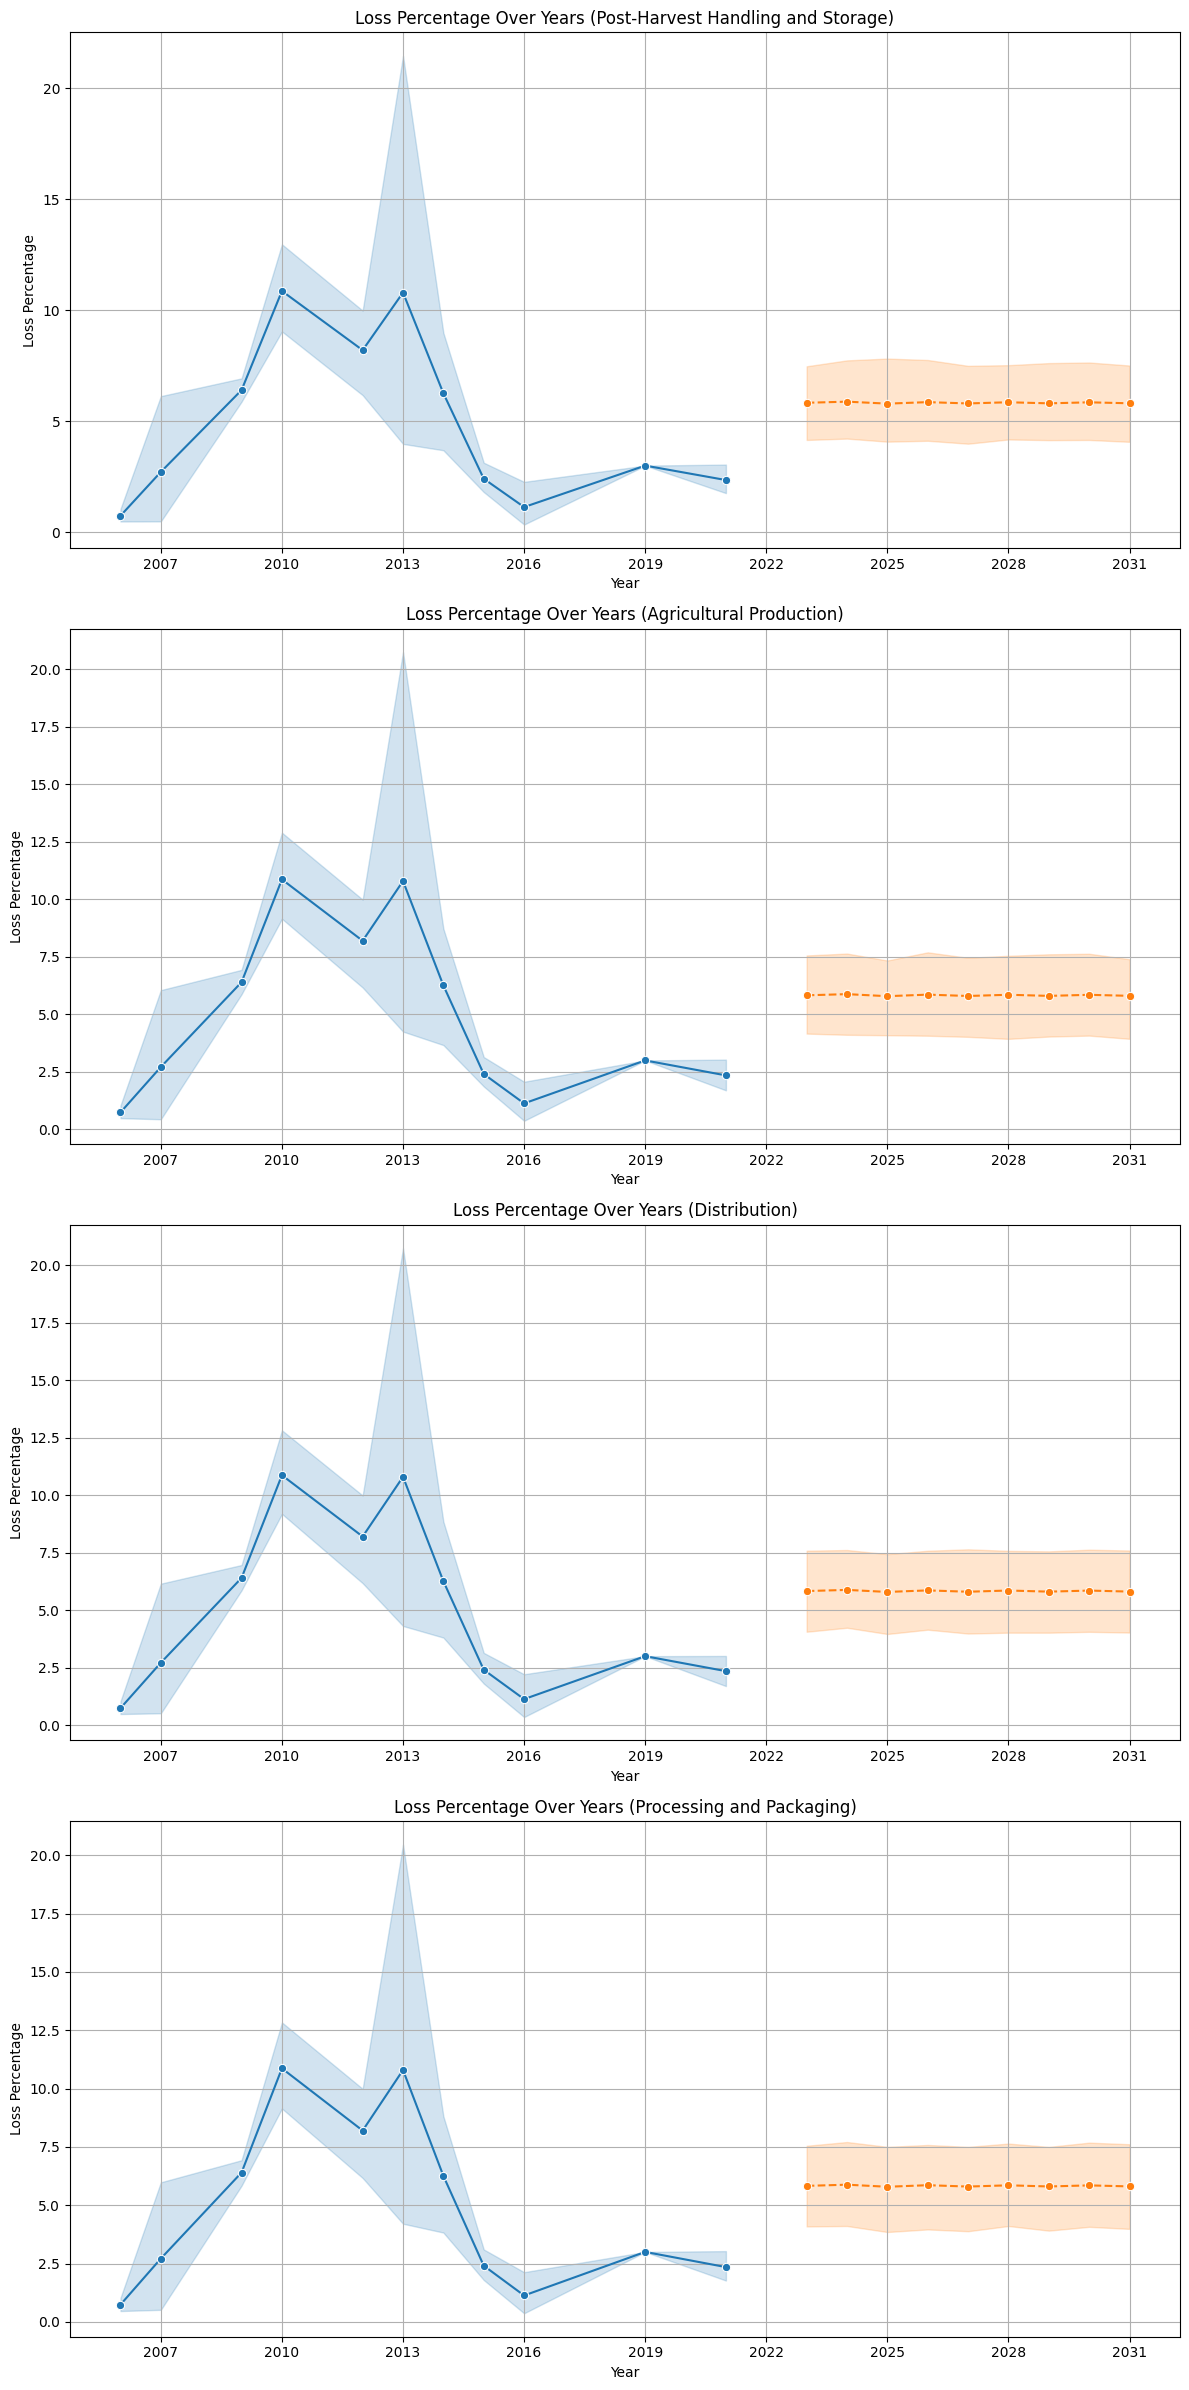

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

combined = pd.read_csv("C:/Users/ProUser/Documents/TSFN Datathon/combined.csv")

historical_years = range(2000, 2023)
future_years = range(2022, 2032)

stages = combined['Stage'].unique()

fig, axes = plt.subplots(nrows=len(stages), figsize=(12, 6 * len(stages)))

for i, stage in enumerate(stages):
    historical_stage = combined[combined['year'].isin(historical_years)]
    future_stage = combined[combined['year'].isin(future_years)]
    
    historical_stage['year'] = historical_stage['year'].round().astype(int)
    future_stage['year'] = future_stage['year'].round().astype(int)
    
    sns.lineplot(x='year', y='loss_percentage', data=historical_stage, palette='tab10', marker='o', linestyle='-', ax=axes[i])
    
    sns.lineplot(x='year', y='forecast_loss_percentage', data=future_stage, palette='pastel', marker='o', linestyle='--', ax=axes[i])
    
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Loss Percentage')
    axes[i].set_title(f'Loss Percentage Over Years ({stage})')
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axes[i].grid(True)

plt.tight_layout()
plt.show()
